In [1]:
%matplotlib inline
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from tools.common import disp_grid
from IPython.display import Image
from skimage.io import imsave

from keras.models import model_from_json
import os
import joblib
import numpy as np
from lightjob.cli import load_db
#from skimage.io import imread
from tools.common import find_generation_job, find_training_job, to_generation
from IPython.display import Image, display
from lightjob.cli import load_db
from lightjob.db import SUCCESS
import pandas as pd

/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [2]:
db = load_db()
jobs = db.jobs_with(state=SUCCESS, where='jobset75')
S = [j['summary'] for j in jobs]
stats = {s: pd.read_csv('../jobs/results/{}/csv/stats.csv'.format(s)) for s in S}

In [3]:
jobs_gen = to_generation(jobs)

In [150]:
model_folder = '../../nnbench/out/feature_generation/5_vs_fake_jobset75'
model = model_from_json(open(os.path.join(model_folder, 'model.json')).read())
model.load_weights(os.path.join(model_folder, 'model.pkl'))

## checking all generated

In [161]:
d = np.load('../exported_data/figs/5_vs_fake_jobset75.npz')
y = d['y']
data = d['X']
data = data[71536:] # test data
y = y[71536:] # test data
data = data[y==10]/255.
print(data.shape)

(16804, 1, 28, 28)


In [162]:
print(set(data.flatten()))

set([0.0, 1.0])


In [163]:
preds = model.predict(data)

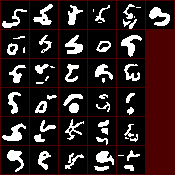

In [164]:
CLASS = 5
p=preds[:, CLASS]
img = data[np.argsort(p)[::-1]]
img = img[ (p[np.argsort(p)[::-1]])>0.5 ]
img = disp_grid(img[0:121], border=1, bordercolor=(0.3, 0, 0))
imsave('imgs/out.png', img)
Image('imgs/out.png')

## checking individual job

In [127]:
job_id = '1a60e00e6264ebd4b8bca146d233e233'
job = db.get_job_by_summary(job_id)
folder = '../jobs/results/{}'.format(job_id)
data = joblib.load(os.path.join(folder, 'images.npz'))
data = data[:, -1] # last time step images

In [10]:
preds = model.predict(data)

[]


In [ ]:
#img = data[ind]
p=preds[:, CLASS]
print(np.max(p))
img = data[np.argsort(p)[::-1]]
img = disp_grid(img[0:100], border=1, bordercolor=(0.3, 0, 0))
fig = plt.figure(figsize=(10, 10))
plt.imshow(img)

In [ ]:
bins = np.linspace(0, 1, 11)
bin_index = np.digitize(preds[:, CLASS], bins)

In [ ]:
w = data.shape[3] * (len(bins)-1)
h = data.shape[2] * (len(bins)*100)
IMG = np.ones((h, w))*0.5
for i in range(1, len(bins)):
    d = data[bin_index==i]
    p = preds[bin_index==i, CLASS]
    s = np.argsort(p)
    p = p[s]
    p = p[::-1]
    d = d[s]
    d = d[::-1]
    x = (i-1) * data.shape[3]
    y=0
    for im in d:
        IMG[y:y+data.shape[2], x:x+data.shape[3]] = im[0, :, :]
        y+=d.shape[2]
    IMG[:, (i-1) * data.shape[3]]=0.3
    for y in range(len(d)):
        IMG[y*d.shape[2], :]=0.3

In [ ]:
plt.hist(preds[:, CLASS])
plt.xlabel('proba of {}'.format(CLASS))
plt.ylabel('freq')

In [ ]:
imsave('out.png',IMG)
Image('out.png')

In [ ]:
plt.plot((stats[find_training_job(job_id)['summary']]['train_recons_error'] / (28*28.)).dropna(), label='train')
plt.plot((stats[find_training_job(job_id)['summary']]['test_recons_error'] / (28*28.)).dropna(), label='test')
plt.xlabel('iter')
plt.legend()
plt.ylabel('reconstruction error')

## checking stats of jobs

In [ ]:
db = load_db()
jobs = db.jobs_with(state=SUCCESS, where='jobset75')
S = [j['summary'] for j in jobs]

In [ ]:
jobs_gen = to_generation(jobs, db=db)

In [ ]:
field = 'stats.out_of_the_box_classification.m2.objectness'
indices = np.arange(len(jobs))
for i in range(len(jobs_gen)):
    j = jobs_gen[i]
    v = db.get_value(j, field, if_not_found=None)
    if not v:print('Misssing generation jobs from training job : {}, skip it.'.format(jobs[i]['summary']))

In [ ]:
field = 'stats.out_of_the_box_classification.m2.objectness'
indices = np.arange(len(jobs))
objectness = map(lambda j:db.get_value(j, field, if_not_found=np.nan), jobs_gen)
objectness = np.array(objectness)
indices = filter(lambda ind:not np.isnan(objectness[ind]), indices)
indices = sorted(indices, key=lambda i:objectness[i])
indices = indices[::-1]
images = ['../exported_data/figs/generated/jobset{:05d}/{}.png'.format(int(jobs[i]['where'][6:]), jobs_gen[i]['summary']) 
          for i in indices]
print(jobs_gen[indices[1]]['summary'])
for i in range(len(images)):
    print(jobs_gen[indices[i]]['summary'])
    display(Image(images[i]), width=100, height=100)